# **Part1**

In [3]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [4]:
predictor_data = pd.read_csv('PredictorData2019.csv')
ff_factors_data = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv')

In [5]:
predictor_data["DATE"] = pd.to_datetime(predictor_data["DATE"], format="%m/%d/%Y") + pd.offsets.MonthEnd(0)
ff_factors_data.rename(columns={"Unnamed: 0": "DATE"}, inplace=True)
ff_factors_data["DATE"] = pd.to_datetime(ff_factors_data["DATE"], format="%Y%m") + pd.offsets.MonthEnd(0)

In [6]:
HML_data = ff_factors_data[["DATE", "HML", "RF"]]
macro_data = predictor_data[["DATE", "tbl", "b/m"]]

df = pd.merge(HML_data, macro_data, on="DATE", how="inner")
df.set_index("DATE", inplace=True)

**Calculate Timing Factor**

In [7]:
df["tbl_change"] = df["tbl"].diff()
df["HML_rolling_12m"] = df["HML"].rolling(window=12).mean()
df["bm_percentile"] = df["b/m"].rank(pct=True)

**Timing Factor**

In [8]:
df["timing_signal"] = 0
df.loc[df["tbl_change"] > 0, "timing_signal"] += 1
df.loc[df["HML_rolling_12m"] > df["HML_rolling_12m"].mean(), "timing_signal"] += 1
df.loc[df["bm_percentile"] > 0.9, "timing_signal"] -= 1

In [9]:
df.dropna(inplace=True)

In [10]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import ttest_ind, ks_2samp
window_size = 60
def backtest_timing_strategy(df, timing_signal_column):
    betas, p_values, timing_returns, r_squared = [], [], [], []


    for i in range(len(df) - window_size):
        train_data = df.iloc[i : i + window_size]

        X_train = sm.add_constant(train_data[[timing_signal_column]])
        Y_train = train_data["HML"]
        model = sm.OLS(Y_train, X_train).fit()

        betas.append(model.params[timing_signal_column])
        p_values.append(model.pvalues[timing_signal_column])
        r_squared.append(model.rsquared)

        next_month = df.iloc[i + window_size]
        if model.params[timing_signal_column] > 0:
            timing_returns.append(next_month["HML"])
        else:
            timing_returns.append(0)

    timing_returns = np.array(timing_returns)
    static_returns = df["HML_rolling_12m"][window_size:].values

    timing_cum_returns = [1]
    static_cum_returns = [1]

    for i in range(len(timing_returns)):
        timing_cum_returns.append(timing_cum_returns[-1] * (1 + timing_returns[i] / 100))
        static_cum_returns.append(static_cum_returns[-1] * (1 + static_returns[i] / 100))

    timing_cum_returns = np.array(timing_cum_returns[1:])
    static_cum_returns = np.array(static_cum_returns[1:])

    def calculate_max_drawdown(cum_returns):
        peaks = np.maximum.accumulate(cum_returns)
        drawdowns = (peaks - cum_returns) / np.where(peaks == 0, 1e-10, peaks)
        return np.nanmax(drawdowns)

    timing_max_dd = calculate_max_drawdown(timing_cum_returns)
    static_max_dd = calculate_max_drawdown(static_cum_returns)

    rf_values = df["RF"].values[window_size:]
    timing_excess_returns = timing_returns / 100 - rf_values
    static_excess_returns = df["HML"].values[window_size:] / 100 - rf_values

    timing_sharpe_ratio = np.mean(timing_excess_returns) / np.std(timing_excess_returns)
    static_sharpe_ratio = np.mean(static_excess_returns) / np.std(static_excess_returns)

    t_stat, p_value = ttest_ind(timing_returns, df["HML"].values[window_size:])
    beta_significance = np.mean(np.array(p_values) < 0.05)
    ks_stat, ks_p_value = ks_2samp(timing_returns, df["HML"].values[window_size:])

    return {
    "timing_cum_returns": timing_cum_returns,
    "static_cum_returns": static_cum_returns,
    "rolling_betas": np.array(betas),
    "rolling_r2": np.array(r_squared),
    "T-statistic": t_stat,
    "P-value": p_value,
    "Beta Significance": beta_significance,
    "Sharpe Ratio (Timing)": timing_sharpe_ratio,
    "Sharpe Ratio (Static)": static_sharpe_ratio,
    "Max Drawdown (Timing)": timing_max_dd,
    "Max Drawdown (Static)": static_max_dd,
    "Kolmogorov-Smirnov Statistic": ks_stat,
    "Kolmogorov-Smirnov P-value": ks_p_value
}


In [11]:
from scipy.stats import ks_2samp
timing_results = {}
timing_results["tbl_change"] = backtest_timing_strategy(df, "tbl_change")
timing_results["HML_rolling_12m"] = backtest_timing_strategy(df, "HML_rolling_12m")
timing_results["bm_percentile"] = backtest_timing_strategy(df, "bm_percentile")
df["combined_signal"] = df["tbl_change"] + df["HML_rolling_12m"] + df["bm_percentile"]
timing_results["combined"] = backtest_timing_strategy(df, "combined_signal")
timing_results_df = pd.DataFrame.from_dict(timing_results, orient="index")
timing_results_df

,timing_cum_returns,static_cum_returns,rolling_betas,rolling_r2,T-statistic,P-value,Beta Significance,Sharpe Ratio (Timing),Sharpe Ratio (Static),Max Drawdown (Timing),Max Drawdown (Static),Kolmogorov-Smirnov Statistic,Kolmogorov-Smirnov P-value
tbl_change,"[0.9892, 1.0010704, 0.9631298318399999, 0.9316...","[1.008575, 1.0137019229166666, 1.0148000999998...","[79.40453236356558, 54.88973476271919, 69.1762...","[0.006965124699095715, 0.003485044799191428, 0...",-1.519788,0.128825,0.072488,-1.367394,-1.366718,0.327234,0.318642,0.355848,1.608080e-34
HML_rolling_12m,"[0.9892, 1.0010704, 0.9631298318399999, 0.9316...","[1.008575, 1.0137019229166666, 1.0148000999998...","[0.7677836155054548, 0.7131930138655034, 0.727...","[0.041391061596410594, 0.03497066600424292, 0....",0.002279,0.998182,0.662273,-1.366707,-1.366718,0.417261,0.318642,0.001647,1.000000e+00
bm_percentile,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.008575, 1.0137019229166666, 1.0148000999998...","[-2.208345417009434, -2.736927970539943, -2.04...","[0.0043561816106449935, 0.0068798484829101225,...",-0.867289,0.385955,0.161450,-1.370018,-1.366718,0.294826,0.318642,0.263591,6.056508e-19
combined,"[0.9892, 1.0010704, 0.9631298318399999, 0.9316...","[1.008575, 1.0137019229166666, 1.0148000999998...","[0.7670414650748624, 0.697078485593387, 0.7161...","[0.03990526916527448, 0.032472511357176215, 0....",0.002279,0.998182,0.611203,-1.366707,-1.366718,0.417261,0.318642,0.001647,1.000000e+00


In [12]:
timing_factors = ["tbl_change", "HML_rolling_12m", "bm_percentile"]
timing_results_dict = {}

for factor in timing_factors:
    timing_results_dict[factor] = backtest_timing_strategy(df, factor)

In [13]:
betas_dict = {factor: timing_results[factor]["rolling_betas"] for factor in timing_results}
r_squared_dict = {factor: timing_results[factor]["rolling_r2"] for factor in timing_results}
timing_cum_returns_dict = {factor: timing_results[factor]["timing_cum_returns"] for factor in timing_results}
static_cum_returns_dict = {factor: timing_results[factor]["static_cum_returns"] for factor in timing_results}
dates = df.index[window_size:]

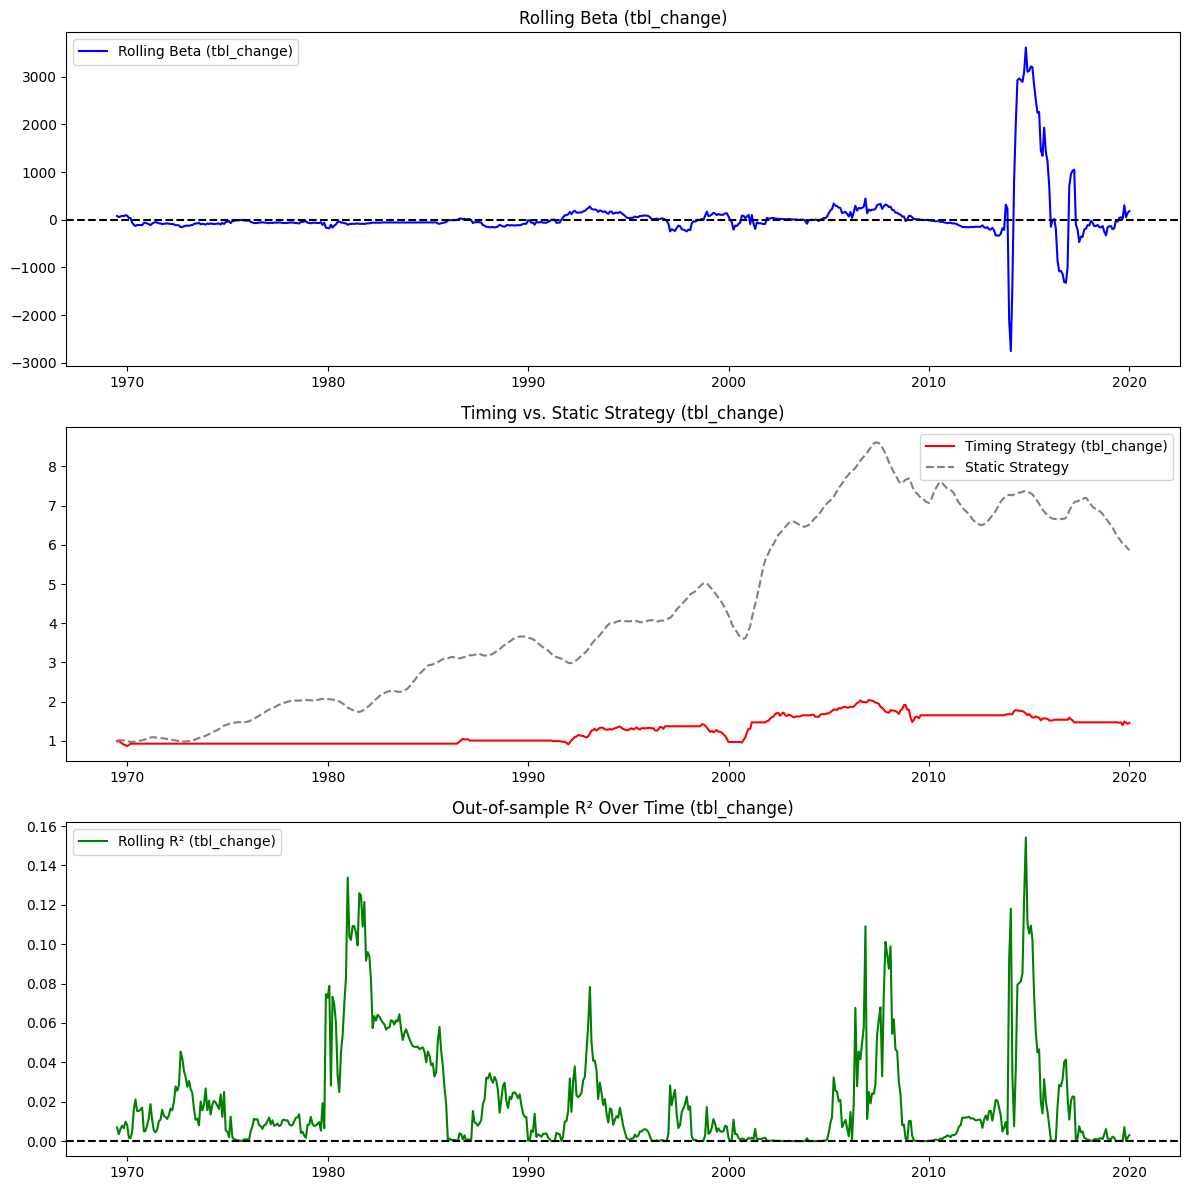

In [14]:
timing_factors = ["tbl_change"]
for factor in timing_factors:
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))

    axes[0].plot(dates, betas_dict[factor], label=f"Rolling Beta ({factor})", color="blue")
    axes[0].axhline(y=0, color="black", linestyle="--")
    axes[0].legend()
    axes[0].set_title(f"Rolling Beta ({factor})")

    axes[1].plot(dates, timing_cum_returns_dict[factor], label=f"Timing Strategy ({factor})", color="red")
    axes[1].plot(dates, static_cum_returns_dict[factor], label="Static Strategy", color="gray", linestyle="--")
    axes[1].legend()
    axes[1].set_title(f"Timing vs. Static Strategy ({factor})")

    axes[2].plot(dates, r_squared_dict[factor], label=f"Rolling R² ({factor})", color="green")
    axes[2].axhline(y=0, color="black", linestyle="--")
    axes[2].legend()
    axes[2].set_title(f"Out-of-sample R² Over Time ({factor})")

    plt.tight_layout()
    plt.show()


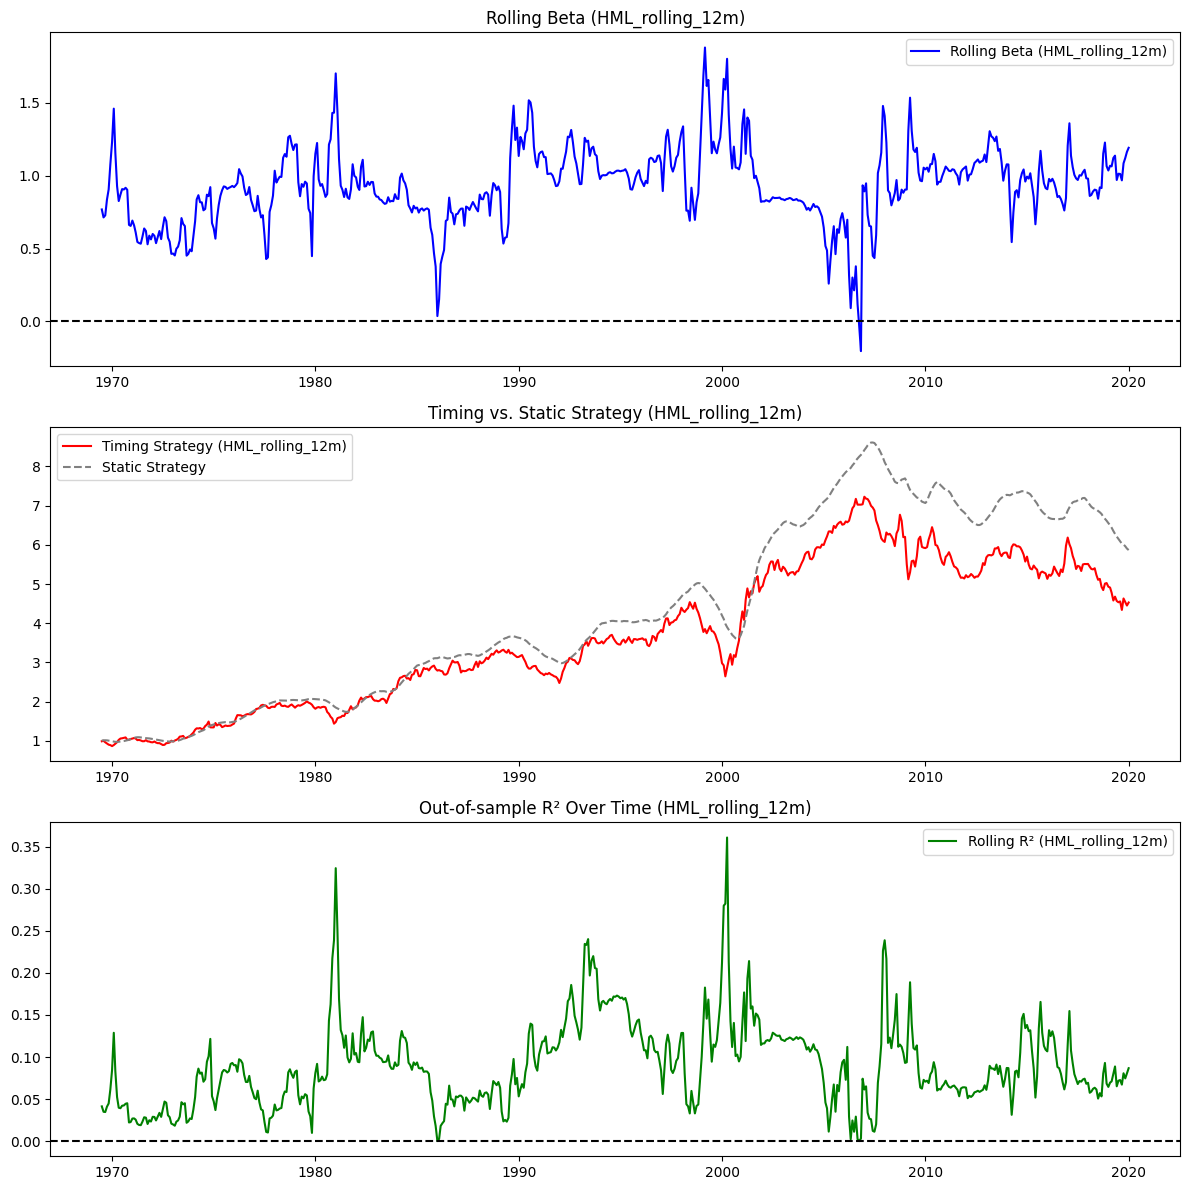

In [15]:
timing_factors = ["HML_rolling_12m"]

for factor in timing_factors:
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))

    axes[0].plot(dates, betas_dict[factor], label=f"Rolling Beta ({factor})", color="blue")
    axes[0].axhline(y=0, color="black", linestyle="--")
    axes[0].legend()
    axes[0].set_title(f"Rolling Beta ({factor})")

    axes[1].plot(dates, timing_cum_returns_dict[factor], label=f"Timing Strategy ({factor})", color="red")
    axes[1].plot(dates, static_cum_returns_dict[factor], label="Static Strategy", color="gray", linestyle="--")
    axes[1].legend()
    axes[1].set_title(f"Timing vs. Static Strategy ({factor})")

    axes[2].plot(dates, r_squared_dict[factor], label=f"Rolling R² ({factor})", color="green")
    axes[2].axhline(y=0, color="black", linestyle="--")
    axes[2].legend()
    axes[2].set_title(f"Out-of-sample R² Over Time ({factor})")

    plt.tight_layout()

    plt.show()

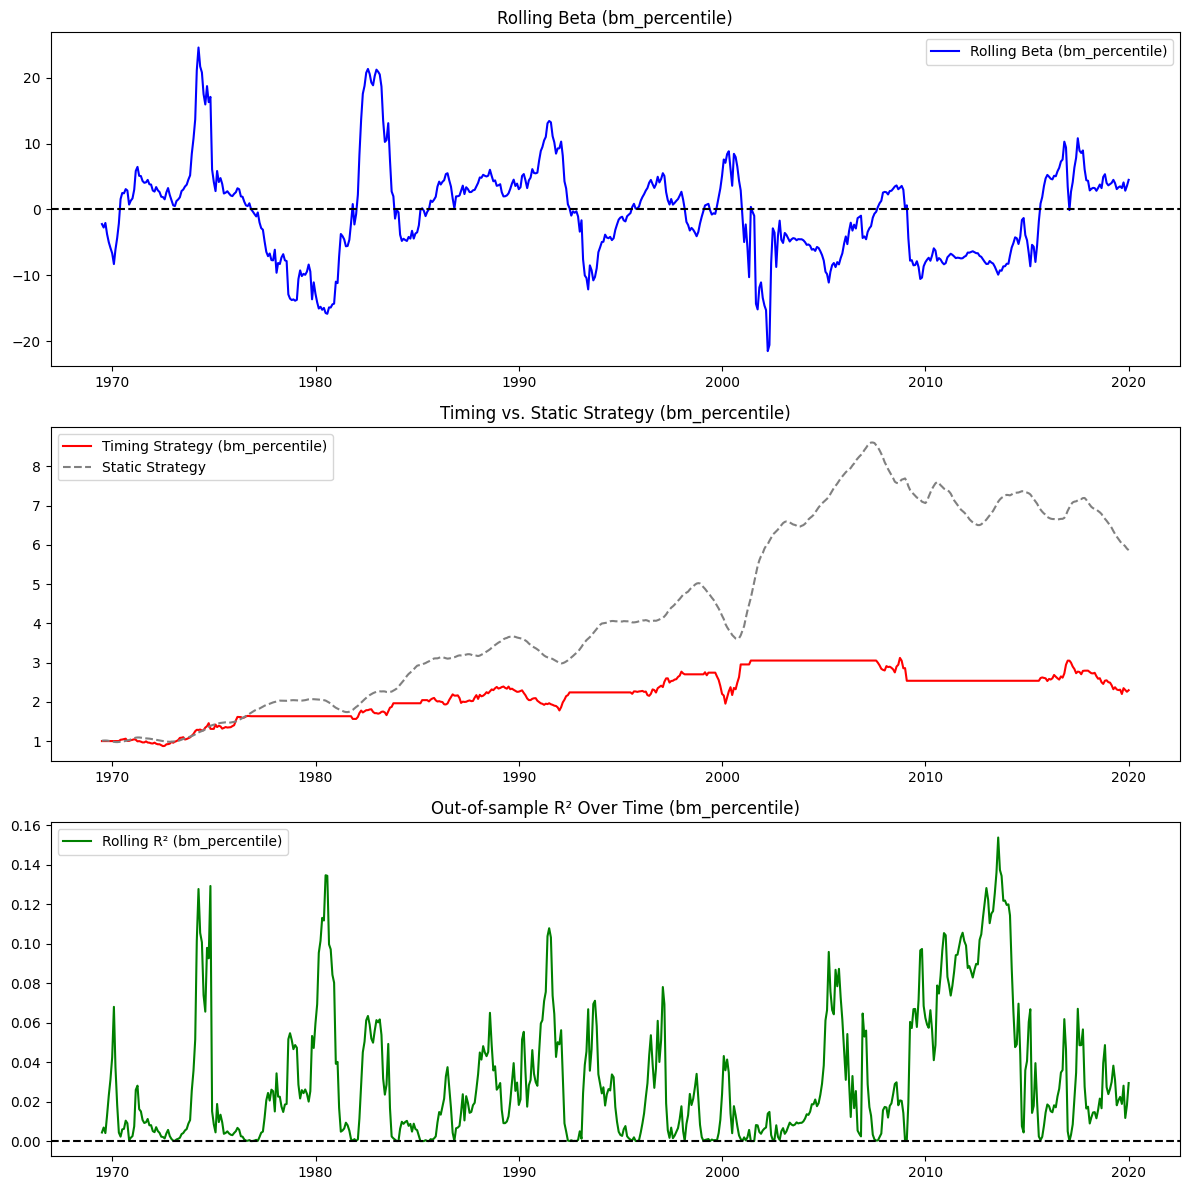

In [16]:
timing_factors = ["bm_percentile"]

for factor in timing_factors:
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))

    axes[0].plot(dates, betas_dict[factor], label=f"Rolling Beta ({factor})", color="blue")
    axes[0].axhline(y=0, color="black", linestyle="--")
    axes[0].legend()
    axes[0].set_title(f"Rolling Beta ({factor})")

    axes[1].plot(dates, timing_cum_returns_dict[factor], label=f"Timing Strategy ({factor})", color="red")
    axes[1].plot(dates, static_cum_returns_dict[factor], label="Static Strategy", color="gray", linestyle="--")
    axes[1].legend()
    axes[1].set_title(f"Timing vs. Static Strategy ({factor})")

    axes[2].plot(dates, r_squared_dict[factor], label=f"Rolling R² ({factor})", color="green")
    axes[2].axhline(y=0, color="black", linestyle="--")
    axes[2].legend()
    axes[2].set_title(f"Out-of-sample R² Over Time ({factor})")

    plt.tight_layout()

    plt.show()


**Try to optimize the feature**

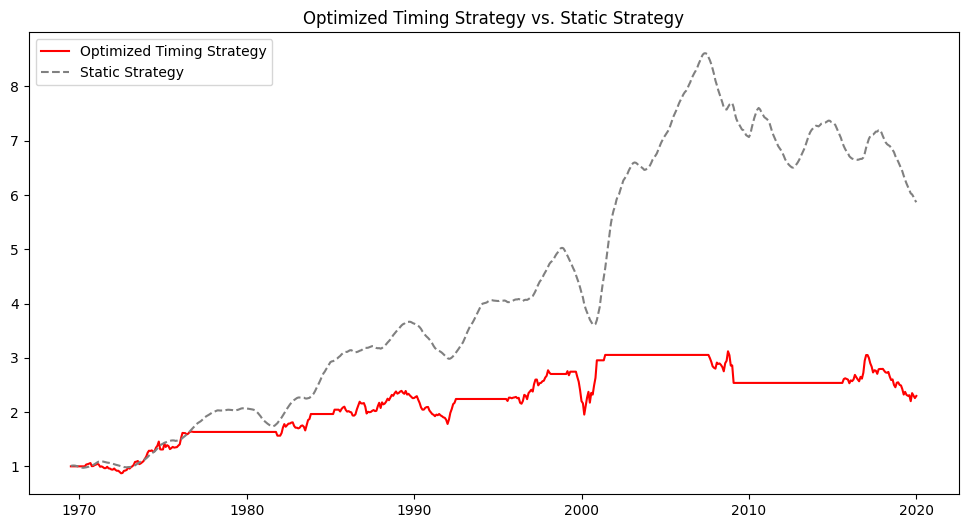

{'Optimized Sharpe Ratio': 0.09220395504887248,
 'Optimized Max Drawdown': array([0.33628421, 0.33487171, 0.33487171, 0.33487171, 0.33487171,
        0.33487171, 0.33487171, 0.33487171, 0.33487171, 0.33487171,
        0.33487171, 0.33487171, 0.33487171, 0.33487171, 0.33487171,
        0.33487171, 0.33487171, 0.33487171, 0.33487171, 0.33487171,
        0.33487171, 0.33487171, 0.33487171, 0.33487171, 0.33487171,
        0.33487171, 0.33487171, 0.33487171, 0.33487171, 0.33487171,
        0.33487171, 0.33487171, 0.33487171, 0.33487171, 0.33487171,
        0.33487171, 0.33487171, 0.33487171, 0.33487171, 0.33487171,
        0.33487171, 0.33487171, 0.33487171, 0.33487171, 0.33487171,
        0.33405225, 0.326666  , 0.32615287, 0.32462857, 0.32462857,
        0.32462857, 0.32462857, 0.32462857, 0.32462857, 0.32221592,
        0.31752736, 0.31292035, 0.31292035, 0.31138686, 0.31138686,
        0.31138686, 0.31027415, 0.3076964 , 0.2949053 , 0.2949053 ,
        0.2949053 , 0.2949053 , 0.2949053 

In [17]:
import numpy as np

df["tbl_change_z"] = (df["tbl_change"] - df["tbl_change"].mean()) / df["tbl_change"].std()
df["HML_rolling_12m_z"] = (df["HML_rolling_12m"] - df["HML_rolling_12m"].mean()) / df["HML_rolling_12m"].std()
df["bm_percentile_z"] = (df["bm_percentile"] - df["bm_percentile"].mean()) / df["bm_percentile"].std()

def sigmoid(x):
    return 2 / (1 + np.exp(-x)) - 1

df["tbl_signal"] = sigmoid(df["tbl_change_z"])
df["HML_signal"] = sigmoid(df["HML_rolling_12m_z"])
df["bm_signal"] = sigmoid(df["bm_percentile_z"])

df["combined_signal"] = (df["tbl_signal"] + df["HML_signal"] + df["bm_signal"]) / 3

optimized_timing_returns = []
for i in range(len(df) - window_size):
    next_month = df.iloc[i + window_size]
    weight = df["combined_signal"].iloc[i + window_size - 1]
    optimized_timing_returns.append(weight * next_month["HML"])

optimized_timing_cum_returns = [1]
for i in range(len(optimized_timing_returns)):
    optimized_timing_cum_returns.append(optimized_timing_cum_returns[-1] * (1 + optimized_timing_returns[i] / 100))

optimized_timing_cum_returns = np.array(optimized_timing_cum_returns[1:])

optimized_max_dd = np.nanmax(np.maximum.accumulate(optimized_timing_cum_returns) - optimized_timing_cum_returns) / np.maximum.accumulate(optimized_timing_cum_returns)
optimized_sharpe_ratio = np.mean(optimized_timing_returns) / np.std(optimized_timing_returns)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates, timing_cum_returns_dict[factor], label="Optimized Timing Strategy", color="red")
ax.plot(dates, static_cum_returns_dict[factor], label="Static Strategy", color="gray", linestyle="--")
ax.legend()
ax.set_title("Optimized Timing Strategy vs. Static Strategy")
plt.show()

optimized_results = {
    "Optimized Sharpe Ratio": optimized_sharpe_ratio,
    "Optimized Max Drawdown": optimized_max_dd,
}

optimized_results

# **Part Two**

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb

**Logistic Regression**

In [19]:
# Load datasets
predictor_data = pd.read_csv('PredictorData2019.csv')
ff_factors_data = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv')

# Format Date Columns
predictor_data["DATE"] = pd.to_datetime(predictor_data["DATE"], format="%m/%d/%Y") + pd.offsets.MonthEnd(0)
ff_factors_data.rename(columns={"Unnamed: 0": "DATE"}, inplace=True)
ff_factors_data["DATE"] = pd.to_datetime(ff_factors_data["DATE"], format="%Y%m") + pd.offsets.MonthEnd(0)

# Extract Relevant Columns
HML_data = ff_factors_data[["DATE", "HML", "RF"]]
macro_data = predictor_data[["DATE", "tbl", "b/m"]]

# Merge DataFrames
df = pd.merge(HML_data, macro_data, on="DATE", how="inner")
df.set_index("DATE", inplace=True)

In [20]:
# Timing Factors
df["tbl_change"] = df["tbl"].diff()  # Treasury Bill Rate Change
df["HML_rolling_12m"] = df["HML"].rolling(window=12).mean()  # 12-month rolling HML
df["bm_percentile"] = df["b/m"].rank(pct=True)  # Book-to-Market Percentile

df.dropna(inplace=True)  # Remove missing values

In [21]:
# Prepare Data for Logistic Regression
X = df[["tbl_change", "HML_rolling_12m", "bm_percentile"]]
y = (df["HML"].shift(-1) > df["HML"].median()).astype(int)

X = sm.add_constant(X)

In [22]:
# Fit Logistic Regression Model
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.681644
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    HML   No. Observations:                  667
Model:                          Logit   Df Residuals:                      663
Method:                           MLE   Df Model:                            3
Date:                Mon, 03 Mar 2025   Pseudo R-squ.:                 0.01656
Time:                        04:29:40   Log-Likelihood:                -454.66
converged:                       True   LL-Null:                       -462.31
Covariance Type:            nonrobust   LLR p-value:                  0.001572
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.3129      0.157     -2.000      0.046      -0.620      -0.006
tbl_change    

In [23]:
# Backtest Logistic Timing Strategy
def backtest_logistic_timing(df, model):
    window_size = 60
    timing_returns = []
    predictions = []

    for i in range(len(df) - window_size):
        train_data = df.iloc[i : i + window_size]

        # Prepare Feature Set (Consistent with Model)
        X_train = sm.add_constant(train_data[["tbl_change", "HML_rolling_12m", "bm_percentile"]])

        # Predict Probability of HML Outperformance
        prob = model.predict(X_train.iloc[-1:])
        signal = 1 if prob.iloc[0] > 0.5 else 0
        predictions.append(prob.iloc[0])

        # Next Period Return
        next_month = df.iloc[i + window_size]
        timing_returns.append(signal * next_month["HML"])

    return np.array(timing_returns), np.array(predictions)

timing_returns_logit, predictions_logit = backtest_logistic_timing(df, logit_model)

In [24]:
# Out-of-Sample R²
r2_logit = r2_score(df["HML"].values[-len(predictions_logit):], predictions_logit)
print(f"Out-of-Sample R² (Logistic Regression): {r2_logit:.3f}")

Out-of-Sample R² (Logistic Regression): 0.001


In [25]:
# Sharpe Ratio
timing_sharpe_logit = np.mean(timing_returns_logit) / np.std(timing_returns_logit)
print(f"Sharpe Ratio (Logistic Timing Strategy): {timing_sharpe_logit:.2f}")

Sharpe Ratio (Logistic Timing Strategy): 0.12


In [26]:
# Apply Trading Costs (10bps, 20bps, 50bps)
cost_levels = [0.001, 0.002, 0.005]  # 10bps, 20bps, 50bps

for cost in cost_levels:
    timing_returns_with_cost = timing_returns_logit - cost
    sharpe_with_cost = np.mean(timing_returns_with_cost) / np.std(timing_returns_with_cost)
    print(f"Sharpe Ratio with {cost*10000:.0f}bps cost: {sharpe_with_cost:.2f}")

Sharpe Ratio with 10bps cost: 0.12
Sharpe Ratio with 20bps cost: 0.12
Sharpe Ratio with 50bps cost: 0.12


In [27]:
# T-Test vs. Static Investment
static_returns = df["HML"].values[-len(timing_returns_logit):]
t_stat, p_value = ttest_ind(timing_returns_logit, static_returns)
print(f"T-Test (Logistic Timing vs. Static): t-stat={t_stat:.3f}, p-value={p_value:.3f}")

T-Test (Logistic Timing vs. Static): t-stat=-0.395, p-value=0.693


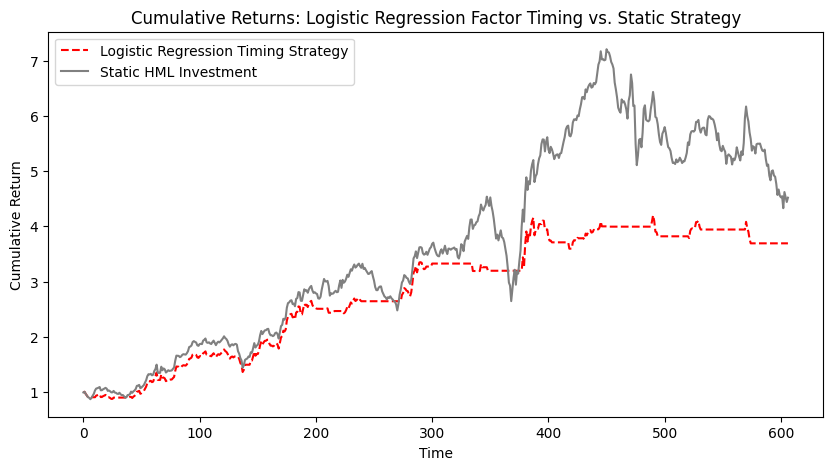

In [28]:
# Plot Cumulative Returns
timing_cum_returns = np.cumprod(1 + timing_returns_logit / 100)
static_cum_returns = np.cumprod(1 + df["HML"].values[-len(timing_returns_logit):] / 100)

plt.figure(figsize=(10, 5))
plt.plot(timing_cum_returns, label="Logistic Regression Timing Strategy", linestyle="--", color="red")
plt.plot(static_cum_returns, label="Static HML Investment", linestyle="-", color="gray")
plt.legend()
plt.title("Cumulative Returns: Logistic Regression Factor Timing vs. Static Strategy")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()

**Random Forest**

In [29]:
# Load Data
predictor_data = pd.read_csv('PredictorData2019.csv')
ff_factors_data = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv')

In [30]:
# Load Data
predictor_data = pd.read_csv('PredictorData2019.csv')
ff_factors_data = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv')

# Format Date Columns
predictor_data["DATE"] = pd.to_datetime(predictor_data["DATE"], format="%m/%d/%Y") + pd.offsets.MonthEnd(0)
ff_factors_data.rename(columns={"Unnamed: 0": "DATE"}, inplace=True)
ff_factors_data["DATE"] = pd.to_datetime(ff_factors_data["DATE"], format="%Y%m") + pd.offsets.MonthEnd(0)

# Extract Relevant Columns
HML_data = ff_factors_data[["DATE", "HML", "RF"]]
macro_data = predictor_data[["DATE", "tbl", "b/m"]]

# Merge DataFrames
df = pd.merge(HML_data, macro_data, on="DATE", how="inner")
df.set_index("DATE", inplace=True)

# Compute Timing Factors
df["tbl_change"] = df["tbl"].diff()
df["HML_rolling_12m"] = df["HML"].rolling(window=12).mean()
df["bm_percentile"] = df["b/m"].rank(pct=True)

# Drop NaN Values
df.dropna(inplace=True)

# Define Features & Target for Random Forest
rf_features = ["tbl_change", "HML_rolling_12m", "bm_percentile"]

# Standardize Features
scaler = StandardScaler()
X_rf_scaled = scaler.fit_transform(df[rf_features])
X_rf_scaled = pd.DataFrame(X_rf_scaled, columns=rf_features, index=df.index)

# Define Binary Target (1 = Above Median HML Next Month, 0 = Below)
y = (df["HML"].shift(-1) > df["HML"].median()).astype(int)

# Drop NaN values in y
y.dropna(inplace=True)
X_rf_scaled = X_rf_scaled.loc[y.index]


In [31]:
# Time-Series Train-Test Split
tscv = TimeSeriesSplit(n_splits=5)
train_idx, test_idx = list(tscv.split(X_rf_scaled))[-1]
X_train_rf, X_test_rf = X_rf_scaled.iloc[train_idx], X_rf_scaled.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Grid Search Hyperparameters
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Train Random Forest with Grid Search
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=tscv, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_rf, y_train)

# Best Model
rf_best = grid_search.best_estimator_
rf_best.fit(X_train_rf, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=42)

In [32]:
# Predict Probability
y_pred_rf = rf_best.predict(X_test_rf)
y_pred_prob_rf = rf_best.predict_proba(X_test_rf)[:, 1]

# Compute R² Score (Out-of-Sample)
r2_rf = r2_score(y_test, y_pred_prob_rf)
print(f"Out-of-Sample R² (Random Forest): {r2_rf:.3f}")

# Compute ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob_rf)
print(f"ROC AUC Score (Random Forest): {roc_auc:.3f}")

Out-of-Sample R² (Random Forest): -0.030
ROC AUC Score (Random Forest): 0.527


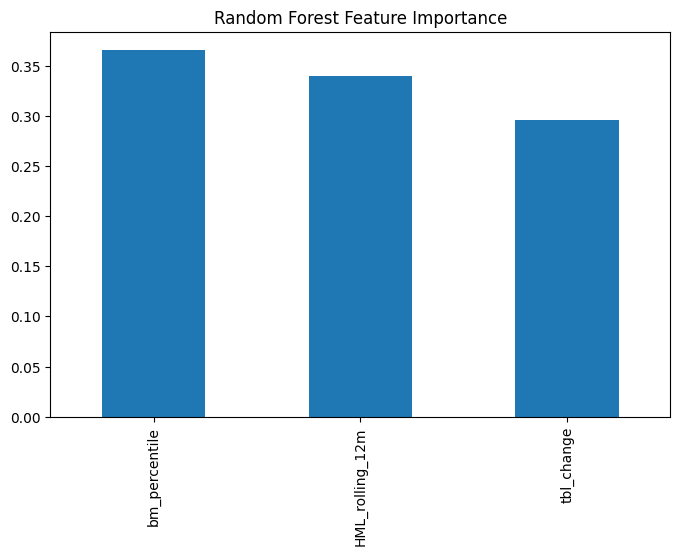

In [33]:
# Feature Importance Plot
feature_importance = pd.Series(rf_best.feature_importances_, index=rf_features)
feature_importance.sort_values(ascending=False).plot(kind="bar", figsize=(8, 5))
plt.title("Random Forest Feature Importance")
plt.show()

In [34]:
def backtest_rf_timing(df, rf_model, scaler):
    window_size = 60
    timing_returns = []
    predictions = []

    for i in range(len(df) - window_size):
        train_data = df.iloc[i : i + window_size]

        # Prepare Feature Set
        X_train = train_data[rf_features]
        X_train_scaled = scaler.transform(X_train)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=rf_features, index=X_train.index)

        # Predict Probability of HML Outperformance
        prob = rf_model.predict_proba(X_train_scaled.iloc[-1].values.reshape(1, -1))[:, 1]
        signal = 1 if prob[0] > 0.5 else 0
        predictions.append(prob[0])

        # Next Period Return
        next_month = df.iloc[i + window_size]
        timing_returns.append(signal * next_month["HML"])

    return np.array(timing_returns), np.array(predictions)

timing_returns_rf, predictions_rf = backtest_rf_timing(df, rf_best, scaler)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

In [35]:
# Cumulative Returns Calculation
timing_cum_returns = [1]
static_cum_returns = [1]

for i in range(len(timing_returns_rf)):
    timing_cum_returns.append(timing_cum_returns[-1] * (1 + timing_returns_rf[i] / 100))
    static_cum_returns.append(static_cum_returns[-1] * (1 + df["HML"].values[i + 60] / 100))

timing_cum_returns = np.array(timing_cum_returns[1:])
static_cum_returns = np.array(static_cum_returns[1:])

# Sharpe Ratio
rf_sharpe_ratio = np.mean(timing_returns_rf) / np.std(timing_returns_rf)

# Max Drawdown
def calculate_max_drawdown(cum_returns):
    peaks = np.maximum.accumulate(cum_returns)
    drawdowns = (peaks - cum_returns) / np.where(peaks == 0, 1e-10, peaks)
    return np.nanmax(drawdowns)

rf_max_dd = calculate_max_drawdown(timing_cum_returns)

# Final Results
rf_results = {
    "Out-of-Sample R²": r2_rf,
    "ROC AUC Score": roc_auc,
    "Sharpe Ratio": rf_sharpe_ratio,
    "Max Drawdown": rf_max_dd
}

print(rf_results)

{'Out-of-Sample R²': -0.03019913097107141, 'ROC AUC Score': 0.527112676056338, 'Sharpe Ratio': 0.32558664771836116, 'Max Drawdown': 0.11508184853999996}


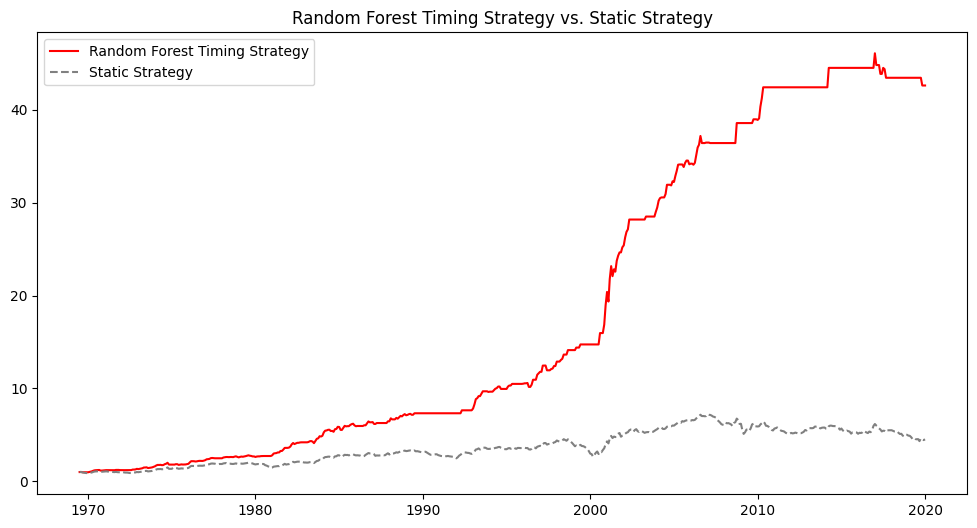

In [36]:
dates = df.index[60:]

# Plot Cumulative Returns
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates, timing_cum_returns, label="Random Forest Timing Strategy", color="red")
ax.plot(dates, static_cum_returns, label="Static Strategy", color="gray", linestyle="--")
ax.legend()
ax.set_title("Random Forest Timing Strategy vs. Static Strategy")
plt.show()

**Gradient Boosting (GBoost)**

In [37]:
# Load Data
predictor_data = pd.read_csv('PredictorData2019.csv')
ff_factors_data = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv')

# Format Date Columns
predictor_data["DATE"] = pd.to_datetime(predictor_data["DATE"], format="%m/%d/%Y") + pd.offsets.MonthEnd(0)
ff_factors_data.rename(columns={"Unnamed: 0": "DATE"}, inplace=True)
ff_factors_data["DATE"] = pd.to_datetime(ff_factors_data["DATE"], format="%Y%m") + pd.offsets.MonthEnd(0)

# Extract Relevant Columns
HML_data = ff_factors_data[["DATE", "HML", "RF"]]
macro_data = predictor_data[["DATE", "tbl", "b/m"]]

# Merge DataFrames
df = pd.merge(HML_data, macro_data, on="DATE", how="inner")
df.set_index("DATE", inplace=True)

# Compute Timing Factors
df["tbl_change"] = df["tbl"].diff()
df["HML_rolling_12m"] = df["HML"].rolling(window=12).mean()
df["bm_percentile"] = df["b/m"].rank(pct=True)

# Drop NaN Values
df.dropna(inplace=True)

# Define Features & Target for GBoost
gboost_features = ["tbl_change", "HML_rolling_12m", "bm_percentile"]

# Standardize Features
scaler = StandardScaler()
X_gboost_scaled = scaler.fit_transform(df[gboost_features])
X_gboost_scaled = pd.DataFrame(X_gboost_scaled, columns=gboost_features, index=df.index)

# Define Binary Target (1 = Above Median HML Next Month, 0 = Below)
y = (df["HML"].shift(-1) > df["HML"].median()).astype(int)

# Drop NaN values in y
y.dropna(inplace=True)
X_gboost_scaled = X_gboost_scaled.loc[y.index]


In [38]:
# Time-Series Train-Test Split
tscv = TimeSeriesSplit(n_splits=5)
train_idx, test_idx = list(tscv.split(X_gboost_scaled))[-1]
X_train_gb, X_test_gb = X_gboost_scaled.iloc[train_idx], X_gboost_scaled.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Grid Search Hyperparameters
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'subsample': [0.5, 0.8, 1.0]
}

# Train Gradient Boosting with Grid Search
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=tscv, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_gb, y_train)

# Best Model
gb_best = grid_search.best_estimator_
gb_best.fit(X_train_gb, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GradientBoostingClassifier(learning_rate=0.05, random_state=42, subsample=0.5)

In [39]:
# Predict Probability
y_pred_gb = gb_best.predict(X_test_gb)
y_pred_prob_gb = gb_best.predict_proba(X_test_gb)[:, 1]

# Compute R² Score (Out-of-Sample)
r2_gb = r2_score(y_test, y_pred_prob_gb)
print(f"Out-of-Sample R² (Gradient Boosting): {r2_gb:.3f}")

# Compute ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob_gb)
print(f"ROC AUC Score (Gradient Boosting): {roc_auc:.3f}")

Out-of-Sample R² (Gradient Boosting): -0.022
ROC AUC Score (Gradient Boosting): 0.546


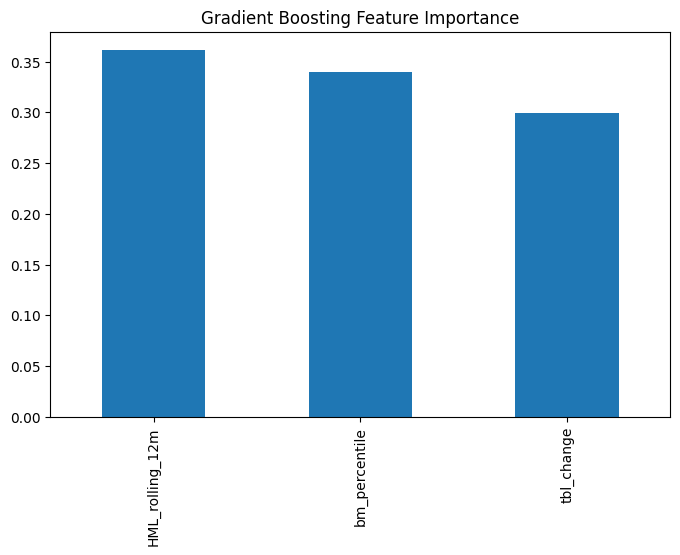

In [40]:
# Feature Importance Plot
feature_importance = pd.Series(gb_best.feature_importances_, index=gboost_features)
feature_importance.sort_values(ascending=False).plot(kind="bar", figsize=(8, 5))
plt.title("Gradient Boosting Feature Importance")
plt.show()

In [41]:
def backtest_gb_timing(df, gb_model, scaler):
    window_size = 60
    timing_returns = []
    predictions = []

    for i in range(len(df) - window_size):
        train_data = df.iloc[i : i + window_size]

        # Prepare Feature Set
        X_train = train_data[gboost_features]
        X_train_scaled = scaler.transform(X_train)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=gboost_features, index=X_train.index)

        # Predict Probability of HML Outperformance
        prob = gb_model.predict_proba(X_train_scaled.iloc[-1].values.reshape(1, -1))[:, 1]
        signal = 1 if prob[0] > 0.5 else 0
        predictions.append(prob[0])

        # Next Period Return
        next_month = df.iloc[i + window_size]
        timing_returns.append(signal * next_month["HML"])

    return np.array(timing_returns), np.array(predictions)

timing_returns_gb, predictions_gb = backtest_gb_timing(df, gb_best, scaler)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warni

In [42]:
# Cumulative Returns Calculation
timing_cum_returns = [1]
static_cum_returns = [1]

for i in range(len(timing_returns_gb)):
    timing_cum_returns.append(timing_cum_returns[-1] * (1 + timing_returns_gb[i] / 100))
    static_cum_returns.append(static_cum_returns[-1] * (1 + df["HML"].values[i + 60] / 100))

timing_cum_returns = np.array(timing_cum_returns[1:])
static_cum_returns = np.array(static_cum_returns[1:])

# Sharpe Ratio
gb_sharpe_ratio = np.mean(timing_returns_gb) / np.std(timing_returns_gb)

# Max Drawdown
def calculate_max_drawdown(cum_returns):
    peaks = np.maximum.accumulate(cum_returns)
    drawdowns = (peaks - cum_returns) / np.where(peaks == 0, 1e-10, peaks)
    return np.nanmax(drawdowns)

gb_max_dd = calculate_max_drawdown(timing_cum_returns)

# Final Results
gb_results = {
    "Out-of-Sample R²": r2_gb,
    "ROC AUC Score": roc_auc,
    "Sharpe Ratio": gb_sharpe_ratio,
    "Max Drawdown": gb_max_dd
}

print(gb_results)

{'Out-of-Sample R²': -0.021724708230696832, 'ROC AUC Score': 0.5459507042253521, 'Sharpe Ratio': 0.36867150839130397, 'Max Drawdown': 0.15909480180412275}


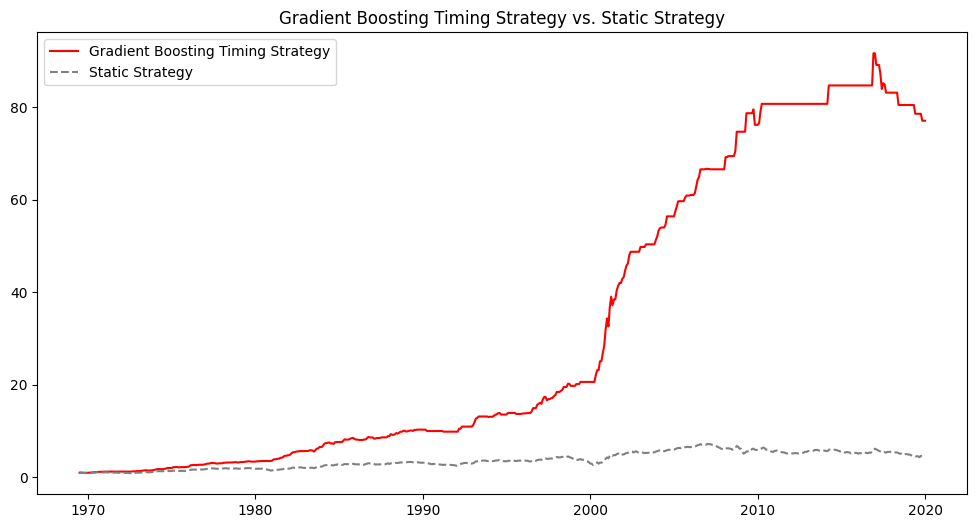

In [43]:
dates = df.index[60:]

# Plot Cumulative Returns
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates, timing_cum_returns, label="Gradient Boosting Timing Strategy", color="red")
ax.plot(dates, static_cum_returns, label="Static Strategy", color="gray", linestyle="--")
ax.legend()
ax.set_title("Gradient Boosting Timing Strategy vs. Static Strategy")
plt.show()

# **Part 3**

**1. Proportional Transaction Costs (Fixed Costs)**

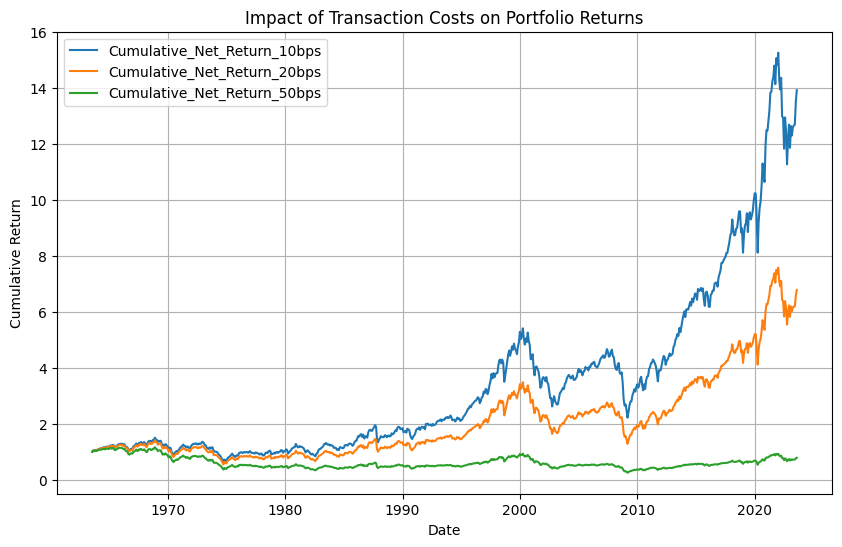

,DATE,Cumulative_Net_Return_10bps,Cumulative_Net_Return_20bps,Cumulative_Net_Return_50bps
716,2023-03-31,12.589928,6.155349,0.716262
717,2023-04-30,12.654137,6.180586,0.717049
718,2023-05-31,12.685772,6.189857,0.715974
719,2023-06-30,13.492587,6.577342,0.758646
720,2023-07-31,13.912207,6.775320,0.779205


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Load the factor returns data
ff_factors_data = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv")
ff_factors_data.rename(columns={"Unnamed: 0": "DATE"}, inplace=True)
ff_factors_data["DATE"] = pd.to_datetime(ff_factors_data["DATE"], format="%Y%m") + pd.offsets.MonthEnd(0)

# Define transaction cost levels (in basis points)
transaction_costs = [0.001, 0.002, 0.005]  # 10bps, 20bps, 50bps

# Calculate gross returns before transaction costs
ff_factors_data["Portfolio_Return"] = ff_factors_data["Mkt-RF"] / 100  # Convert to decimal

# Apply transaction costs
for cost in transaction_costs:
    col_name = f"Net_Return_{int(cost*10000)}bps"
    ff_factors_data[col_name] = ff_factors_data["Portfolio_Return"] - cost

# Calculate cumulative returns
for col in [f"Net_Return_{int(c*10000)}bps" for c in transaction_costs]:
    ff_factors_data[f"Cumulative_{col}"] = (1 + ff_factors_data[col]).cumprod()

# Line Graph: Cumulative Returns
plt.figure(figsize=(10,6))
for col in [f"Cumulative_Net_Return_{int(c*10000)}bps" for c in transaction_costs]:
    plt.plot(ff_factors_data["DATE"], ff_factors_data[col], label=col)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Impact of Transaction Costs on Portfolio Returns")
plt.legend()
plt.grid(True)
plt.show()

# Display results
display_cols = ["DATE"] + [f"Cumulative_Net_Return_{int(c*10000)}bps" for c in transaction_costs]
display(ff_factors_data[display_cols].tail())


**2. Portfolio Turnover & Rebalancing Frequency**

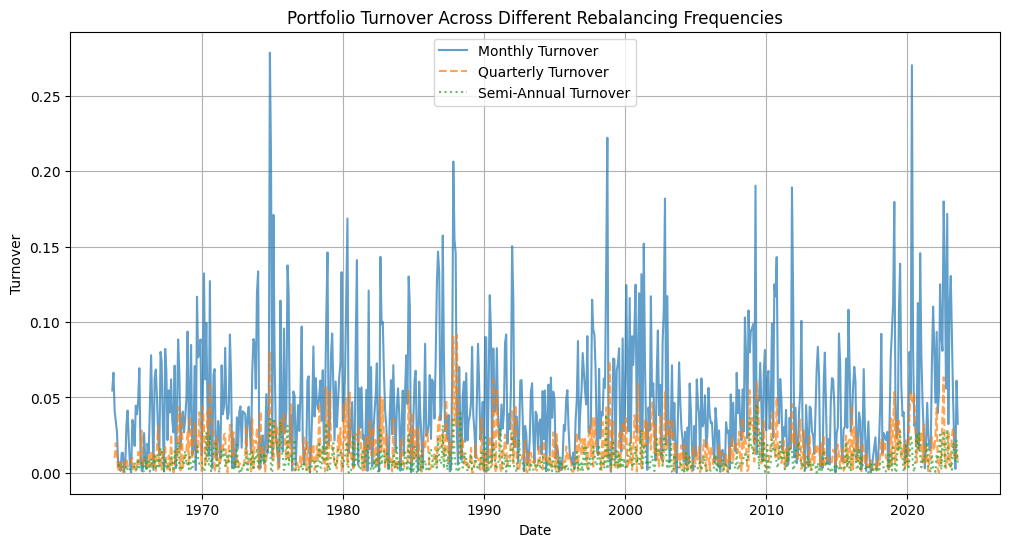

,DATE,Turnover_Monthly,Turnover_Quarterly,Turnover_Semi-Annual
716,2023-03-31,0.0509,0.029733,0.019767
717,2023-04-30,0.0190,0.020133,0.012033
718,2023-05-31,0.0026,0.009767,0.007083
719,2023-06-30,0.0611,0.013167,0.021450
720,2023-07-31,0.0325,0.008667,0.005733


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Load the factor returns data
ff_factors_data = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv")
ff_factors_data.rename(columns={"Unnamed: 0": "DATE"}, inplace=True)
ff_factors_data["DATE"] = pd.to_datetime(ff_factors_data["DATE"], format="%Y%m") + pd.offsets.MonthEnd(0)

# Define rebalancing frequency options
rebalancing_options = {"Monthly": 1, "Quarterly": 3, "Semi-Annual": 6}

# Calculate returns for different rebalancing frequencies
for period, freq in rebalancing_options.items():
    col_name = f"Return_{period}"
    ff_factors_data[col_name] = ff_factors_data["Mkt-RF"].rolling(freq).mean() / 100  # Convert to decimal

# Compute turnover: absolute change in position over time
ff_factors_data["Turnover_Monthly"] = ff_factors_data["Return_Monthly"].diff().abs()
ff_factors_data["Turnover_Quarterly"] = ff_factors_data["Return_Quarterly"].diff().abs()
ff_factors_data["Turnover_Semi-Annual"] = ff_factors_data["Return_Semi-Annual"].diff().abs()

# Line Graph: Turnover Across Different Rebalancing Frequencies
plt.figure(figsize=(12,6))
plt.plot(ff_factors_data["DATE"], ff_factors_data["Turnover_Monthly"], label="Monthly Turnover", linestyle='-', alpha=0.7)
plt.plot(ff_factors_data["DATE"], ff_factors_data["Turnover_Quarterly"], label="Quarterly Turnover", linestyle='--', alpha=0.7)
plt.plot(ff_factors_data["DATE"], ff_factors_data["Turnover_Semi-Annual"], label="Semi-Annual Turnover", linestyle=':', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Turnover")
plt.title("Portfolio Turnover Across Different Rebalancing Frequencies")
plt.legend()
plt.grid(True)
plt.show()

# Display results
display_cols = ["DATE", "Turnover_Monthly", "Turnover_Quarterly", "Turnover_Semi-Annual"]
display(ff_factors_data[display_cols].tail())


**3. Quadratic Transaction Costs (Market Impact)**

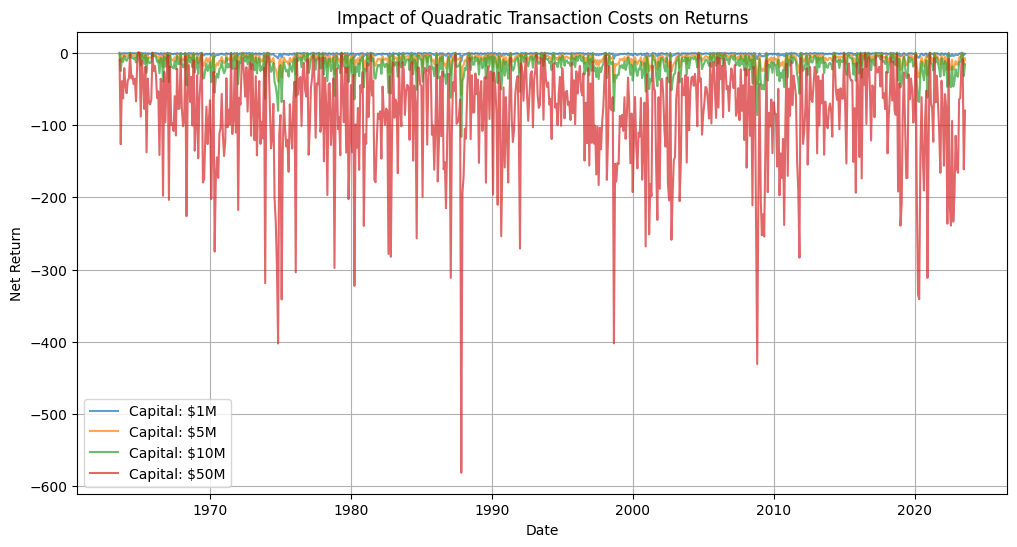

,DATE,Net_Return_Cap_1M,Net_Return_Cap_5M,Net_Return_Cap_10M,Net_Return_Cap_50M
716,2023-03-31,-1.2309,-6.2509,-12.5259,-62.7259
717,2023-04-30,-0.2999,-1.5199,-3.0449,-15.2449
718,2023-05-31,-0.1725,-0.8725,-1.7475,-8.7475
719,2023-06-30,-3.1664,-16.0864,-32.2364,-161.4364
720,2023-07-31,-1.5739,-7.9939,-16.0189,-80.2189


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Load the factor returns data
ff_factors_data = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv")
ff_factors_data.rename(columns={"Unnamed: 0": "DATE"}, inplace=True)
ff_factors_data["DATE"] = pd.to_datetime(ff_factors_data["DATE"], format="%Y%m") + pd.offsets.MonthEnd(0)

# Define quadratic transaction cost parameters
capital_levels = [1e6, 5e6, 10e6, 50e6]  # $1M to $50M capital
base_transaction_cost = 0.001  # 10bps base cost
market_impact_factor = 0.00005  # Impact grows with trade size

# Compute quadratic transaction costs for different capital levels
for capital in capital_levels:
    turnover = ff_factors_data["Mkt-RF"].abs() / 100  # Approximate turnover
    cost_col = f"Cost_Cap_{int(capital/1e6)}M"
    ff_factors_data[cost_col] = base_transaction_cost + market_impact_factor * (capital * turnover)
    ff_factors_data[f"Net_Return_Cap_{int(capital/1e6)}M"] = ff_factors_data["Mkt-RF"] / 100 - ff_factors_data[cost_col]

# Line Graph: Net Returns After Quadratic Transaction Costs
plt.figure(figsize=(12,6))
for capital in capital_levels:
    col_name = f"Net_Return_Cap_{int(capital/1e6)}M"
    plt.plot(ff_factors_data["DATE"], ff_factors_data[col_name], label=f"Capital: ${int(capital/1e6)}M", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Net Return")
plt.title("Impact of Quadratic Transaction Costs on Returns")
plt.legend()
plt.grid(True)
plt.show()

# Display results
display_cols = ["DATE"] + [f"Net_Return_Cap_{int(c/1e6)}M" for c in capital_levels]
display(ff_factors_data[display_cols].tail())
